In [3]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
import pandas as pd
import gpflow_tools.mean_func as mf
from random import sample
import gpflow_tools.kernels as kern
import validation.metrics as metrics
from sklearn.model_selection import KFold

In [5]:
data = pd.read_excel('Data/full_data_10_08.xlsx')
cols = ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
for c in data.columns:
    if 'afp' in c or 'bfp' in c or 'mpf' in c or 'efp' in c:
        cols.append(c)

In [6]:
for i in data.index:
    if data.loc[i, 'Shear_Rate'] == 0:
        #data.loc[i,'Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data = data.drop([i])

for c in ['Mw', 'Melt_Viscosity', 'Shear_Rate']:
    data[c] = np.log10(data[c])

In [ ]:
data

In [7]:
filtered_data = data.loc[:, cols].dropna()
X_tot = np.array(filtered_data.drop(columns=['Melt_Viscosity']))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [20]:
# kf = KFold(n_splits=5)
# for train_index, test_index in kf.split(X_tot):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X, xx = X_tot[train_index], X_tot[test_index]
#     Y, yy = Y_tot[train_index], Y_tot[test_index]
# test_samples = sample(range(tot_samples), round(tot_samples/5))
# train_samples = [i for i in range(tot_samples) if i not in test_samples]
# X = X_tot[train_samples]
# Y = Y_tot[train_samples]
# xx = X_tot[test_samples]
# yy = Y_tot[test_samples]

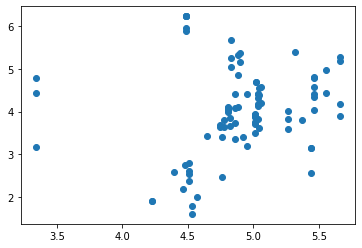

In [21]:
plt.scatter(xx[:,0],yy)
#plt.plot(X, np.power(X,2) + X)

0.7738589320381186


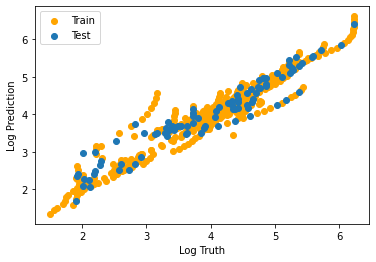

1.011402060004995


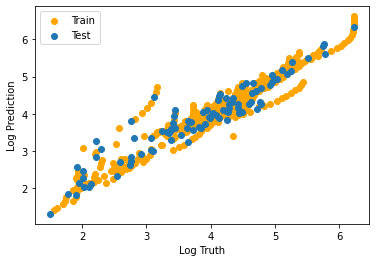

0.9969091806139381


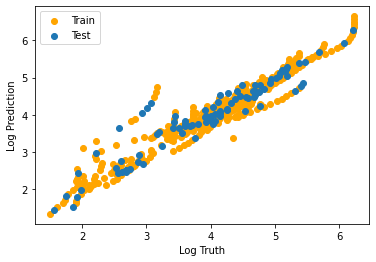

0.38050289514893626


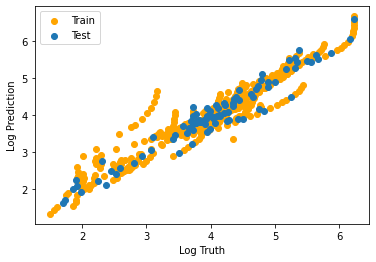

1.1463471347099246


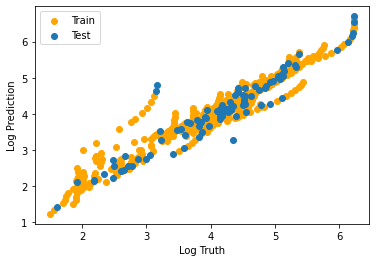

In [8]:
#A = np.concatenate((np.array([3.4]), np.zeros(X_tot.shape[1] - 1))).reshape(-1,1)
#mf = gpflow.mean_functions.Linear(A = A, b = np.zeros((1)))
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(X_tot):
    X, xx = X_tot[train_index], X_tot[test_index]
    Y, yy = Y_tot[train_index], Y_tot[test_index]
    mean_mol = mf.mol_weight_mean(X_tot.shape[1])
    mean_temp = mf.temp_mean()
    mean = mf.weight_temp_mean(input_dim = X_tot.shape[1])
    mean_s = mf.shear_mean(input_dim = X_tot.shape[1])
    k = gpflow.kernels.SquaredExponential()
    k_tan =  kern.Tanimoto()
    m = gpflow.models.GPR(data=(X, Y), kernel=k_tan, mean_function= mean_s)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
    mean, var = m.predict_y(xx)
    print(metrics.MAPE(mean, yy))
    mean_train, var_train = m.predict_y(X)
    plt.scatter(Y, mean_train, c = 'orange')
    plt.scatter(yy, mean)
    plt.ylabel('Log Prediction')
    plt.xlabel('Log Truth')
    plt.legend(['Train','Test'])
    plt.show()

0.5582207185205144
2.537471895740793


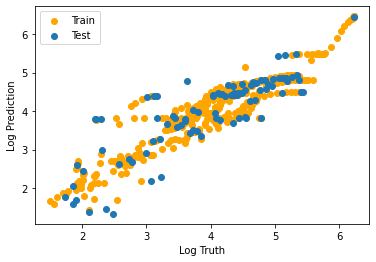

In [23]:
## predict mean and variance of latent GP at test points
mean, var = m.predict_y(xx)
## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# # plot
# plt.figure(figsize=(12, 6))
# #plt.plot(X[:,0], Y, "kx", mew=2)
# plt.plot(xx, mean, "C0", lw=2)
# plt.fill_between(
#     xx[:, 0],
#     mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
#     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
#     color="C0",
#     alpha=0.2,
# )

# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
mean_train, var_train = m.predict_y(X)
plt.scatter(Y, mean_train, c = 'orange')
plt.scatter(yy, mean)
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Train','Test'])
rmse = metrics.RMSE(mean, yy)
mape = metrics.MAPE(mean, yy)
print(rmse)
print(mape)

0.8182853529958639


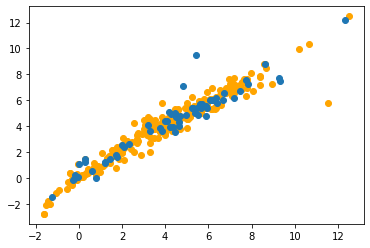

In [213]:
## predict mean and variance of latent GP at test points
mean, var = m.predict_y(xx)
## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# # plot
# plt.figure(figsize=(12, 6))
# #plt.plot(X[:,0], Y, "kx", mew=2)
# plt.plot(xx, mean, "C0", lw=2)
# plt.fill_between(
#     xx[:, 0],
#     mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
#     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
#     color="C0",
#     alpha=0.2,
# )

# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
mean_train, var_train = m.predict_y(X)
plt.scatter(Y, mean_train, c = 'orange')
plt.scatter(yy, mean)
rmse = np.sqrt(np.sum(np.power((yy-mean),2)/len(yy)))
print(rmse)

In [13]:
l = np.ones((3,5))

In [15]:
l[:, 0:]

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [64]:
metrics.MAPE(mean, yy)

0.41405276150541603